In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")

# Metroplis Hasting

In [2]:
def affine_z(z, a, b):
    return(a*z+b)

def unnormalised_true_dist(z):
    a = 10; b = 3
    pz = np.exp(-z**2)*expit(affine_z(z,a,b))
    return pz

def next_state(current_state, tau):
    transition_dist = norm(loc = current_state, scale = tau)
    return(transition_dist.rvs(1))

def accept_prob(pos_dist, current_state, next_state):
    current_state_p = pos_dist(current_state)
    next_state_p = pos_dist(next_state)
    return(np.min([1, next_state_p/current_state_p]))

def true_dist(a, b, x_min, x_max, n_samples):
    z = np.linspace(x_min, x_max, n_samples)
    F = compute_gauss_hermite_approx(z,a,b)
    pz = unnormalised_true_dist(z)/F
    plt.plot(z, pz, "r", linewidth=2.0)
    plt.xlabel("z")
    plt.ylabel("probability")
    
def compute_gauss_hermite_approx(z, a, b):
    degree = 100
    def only_sigmoid(z):
        # returns sigmoid(ax + b) for function exp(-x^2)*sigmoid(10x+3)
        return (expit(a*z+b))
    points, weights = np.polynomial.hermite.hermgauss( degree)	# points.shape = weights.shape = (degree,)
    F = np.sum(only_sigmoid(points) * weights)
    return (F)

def metropolis_hasting(true_dist, n_iter, burn_in, m, tau):

    tau = np.sqrt(tau)
    z_p = 0 #initial value of z
    rejected = np.array([])
    accepted = np.array([])

    for i in range(1, burn_in+1):
        z_n = next_state(z_p, tau)
        prob = accept_prob(true_dist, z_p, z_n)
        u = np.random.uniform(0, 1, 1)
        if (u <= prob):
            z_p = z_n
#     print("Burn-in for "+str(burn_in)+" iterations done!")
    for i in range(1, n_iter+1):
        accept = False
        z_n = next_state(z_p, tau)
        prob = accept_prob(true_dist, z_p, z_n)
        u = np.random.uniform(0,1,1)
        if(u<=prob):
            accept = True
        if(i%m == 0):
            if(accept):
                accepted = np.hstack((accepted, z_n))
            else:
                accepted = np.hstack((accepted, z_p))
                rejected = np.hstack((rejected, z_n))
        if(accept):
            z_p = z_n
#     print("Sampling for " +str(n_iter) + " iterations done!")
    return accepted, rejected


                   METROPOLIS HASITNG SAMPLING                         


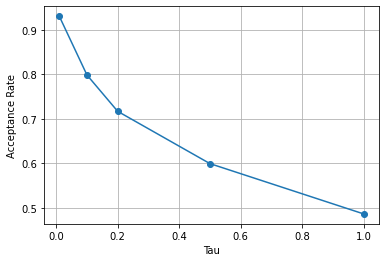

In [6]:
print("\n=======================================================================")
print("                   METROPOLIS HASITNG SAMPLING                         ")
print("=======================================================================")

n_iter = 50000
burn_in = 100000

m = 10 ; a = 10; b = 3
tau_val = [0.01, 0.1, 0.2, 0.5, 1]
accept_rate = np.array([])
plots = []

for tau in tau_val:
#     print("\n\ntau = ", tau)
    accepted, rejected = metropolis_hasting(unnormalised_true_dist, n_iter, burn_in, m, tau)
    accept_rate = np.hstack((accept_rate, rejected.shape[0]/accepted.shape[0]))
    plots.append(accepted)
#     print("Accept Rate ", 1 - accept_rate[-1])
#     plt.hist(accepted, bins=50, density=True)
#     true_dist(a, b, -5, 5, 500)      # get true distribution
#     plt.legend(["True_dist", "tau="+str(tau)])
#     plt.savefig("metropolis_hasting_tau"+str(tau).replace('.','_')+".png")
#     plt.clf()
#     plt.show()

accept_rate = (1 - accept_rate)
#print(accept_rate)
plt.clf()
plt.plot(tau_val, accept_rate, marker='o')
plt.grid()
plt.xlabel("Tau")
plt.ylabel("Acceptance Rate")
plt.show()

In [ ]:
fig, axs = plt.subplots(3, 2, subplot_kw=dict(projection="polar"))

# Hybrid Monte Carlo

In [4]:
def total_energy(state):
    z = state[0]
    r = state[1]
    s = state[2]
    u = z**2 - np.log(expit(affine_z(z,a,b)))
    k = 0.5*r*r/s
    return(1/np.exp(u+k))

def dU_dz(z):
    grad = 2*z - (1 - expit(affine_z(z,a,b)))*a
    return(grad)

def leapfrog(z, r, s, eps, L):

    for i in range(L):
        r -= (eps/2)*dU_dz(z)
        z += eps*r/s
        r -= (eps/2)*dU_dz(z)
    return (z, r)

def hybrid_monte_carlo(pos_dist, n_iter, burn_in, m, eps, L):

    s = 1
    r = norm(loc=0, scale=np.sqrt(s))
    z_p = np.array([2], dtype=np.float)  # initial value of z
    rejected = np.array([])
    accepted = np.array([])

    for i in range(1, burn_in + 1):
        r_p = r.rvs(1)  # sampling r from normal distribution
        z_n, r_n = leapfrog(np.copy(z_p), np.copy(r_p), s, eps, L)
        r_n*=(-1)
        prob = accept_prob(pos_dist, [z_p, r_p, s], [z_n, r_n, s])
        u = np.random.uniform(0, 1, 1)
        if (u <= prob):
            z_p = z_n
#     print("Burn-in for " + str(burn_in) + " iterations done!")

    for i in range(1, n_iter + 1):
        accept = False
        r_p = r.rvs(1)  # sampling r from normal distribution
        z_n, r_n = leapfrog(np.copy(z_p), np.copy(r_p), s, eps, L)
        r_n *= (-1)
        prob = accept_prob(pos_dist, [z_p, r_p, s], [z_n, r_n, s])
        u = np.random.uniform(0, 1, 1)
        if (u <= prob):
            accept = True
        if (i % m == 0):
            if (accept):
                accepted = np.hstack((accepted, z_n))
            else:
                accepted = np.hstack((accepted, z_p))
                rejected = np.hstack((rejected, z_n))
        if (accept):
            z_p = z_n
#     print("Sampling for "+str(n_iter) + " iterations done!")
    return accepted, rejected

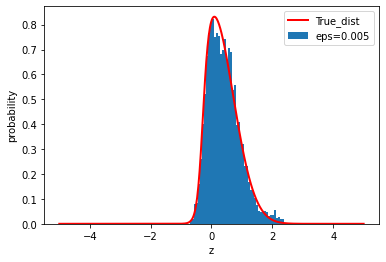

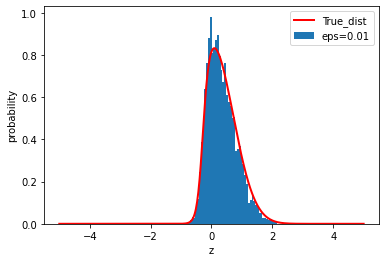

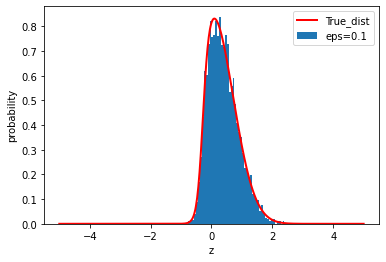

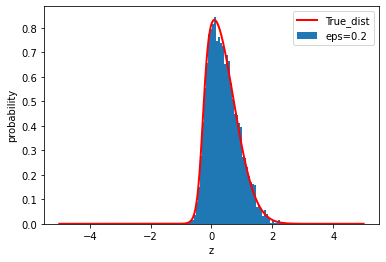

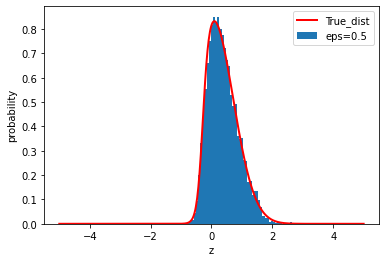

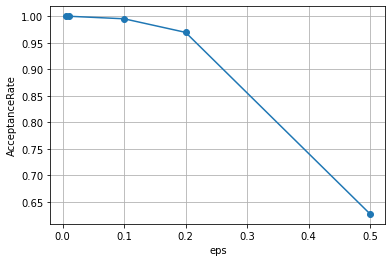

In [5]:
L = 10
eps_val = [0.005, 0.01, 0.1, 0.2, 0.5]
accept_rate = np.array([])

for eps in eps_val:
#     plt.clf()
#     print("\n\nepsilon = ", eps, "\t L = ", L)
    accepted, rejected = hybrid_monte_carlo(total_energy, n_iter, burn_in, m, eps, L)
    accept_rate = np.hstack((accept_rate, rejected.shape[0]/accepted.shape[0]))
#     print("Accept Rate ", 1 - accept_rate[-1])
    plt.hist(accepted, bins=50, density=True)
    true_dist(a, b, -5, 5, 500)      # get true distribution
    plt.legend(["True_dist", "eps="+str(eps)])
    plt.show()
    plt.savefig("hybrid_monte_carlo_"+str(eps).replace('.','_')+".png")


accept_rate = (1 - accept_rate)
# print(accept_rate)
plt.clf()
plt.plot(eps_val, accept_rate, marker='o')
plt.xlabel("eps")
plt.ylabel("AcceptanceRate")
plt.grid()